# Interaction heatmaps for loci of interest grouped by EV1

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler
import re
import bbi
from pybedtools import bedtool
import pybedtools
import pyranges
from matplotlib.gridspec import GridSpec
from cooltools import snipping
import scipy

In [12]:
mm10 = bioframe.fetch_chromsizes('mm10')
chromsizes = bioframe.fetch_chromsizes('mm10')
chromosomes = list(chromsizes.index)


# Fetch matrices and normalise by expected values

In [13]:
#using read normalised data
filepath_dmso_ND='/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/cooler/JZ-MEF-AsiS1-ND-dmso6h-pool.mm10.nodups.112.1000.mcool::resolutions/250000'
filepath_dmso_4OHT='/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/cooler/JZ-MEF-AsiS1-4OHT-dmso6h-pool.mm10.nodups.112.1000.mcool::resolutions/250000'

c_dmso_ND = cooler.Cooler(filepath_dmso_ND)
c_dmso_4OHT = cooler.Cooler(filepath_dmso_4OHT)


In [14]:
resolution = c_dmso_ND.binsize
#Chr 1 example
mat_dmso_ND = c_dmso_ND.matrix(balance=True).fetch('chr1')
mat_dmso_4OHT = c_dmso_4OHT.matrix(balance=True).fetch('chr1')


In [15]:
#CIS
exp_dmso_ND=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/JZ-MEF-AsiS1-ND-dmso6h-HiCD2R2.mm10.250000.cis.expected', sep="\t")
exp_dmso_ND=exp_dmso_ND[exp_dmso_ND['chrom']=="chr1"]

exp_dmso_4OHT=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R2.mm10.250000.cis.expected', sep="\t")
exp_dmso_4OHT=exp_dmso_4OHT[exp_dmso_4OHT['chrom']=="chr1"]

exp_dmso_4OHT.head()


,chrom,diag,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
0,chr1,0,769,NaN,NaN,NaN,NaN
1,chr1,1,768,NaN,NaN,NaN,NaN
2,chr1,2,767,81514.0,28.977592,106.276402,0.037780
3,chr1,3,766,45357.0,16.727350,59.212794,0.021837
4,chr1,4,765,29002.0,10.990307,37.911111,0.014366


In [16]:
##FOR CIS
exp_dmso_ND_np=exp_dmso_ND['balanced.avg'].to_numpy()
exp_dmso_4OHT_np=exp_dmso_4OHT['balanced.avg'].to_numpy()


In [17]:
##for cis (in trans is a scalar)
from numpy import concatenate, zeros
from scipy.linalg import toeplitz

mat_exp_dmso_ND_np=toeplitz(exp_dmso_ND_np)
mat_exp_dmso_4OHT_np=toeplitz(exp_dmso_4OHT_np)

mat_exp_dmso_ND_np


array([[      nan,       nan, 0.0456094, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [0.0456094,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
        0.0456094],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ..., 0.0456094,       nan,
              nan]])

In [18]:
###CIS
mat_dmso_ND_oe=np.divide(mat_dmso_ND,mat_exp_dmso_ND_np)
mat_dmso_ND_oe=np.nan_to_num(mat_dmso_ND_oe)
mat_dmso_4OHT_oe=np.divide(mat_dmso_4OHT,mat_exp_dmso_4OHT_np)
mat_dmso_4OHT_oe=np.nan_to_num(mat_dmso_4OHT_oe)
mat_dmso_ND_oe


/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.54795479],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.54795479, 0.        ,
        0.        ]])

In [19]:
mat_dmso_4OHT_oe.shape

(782, 782)

# Create index for flipped EV1 bins and fetch interactions

In [20]:
eig1=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/JZ-MEF-AsiS1-ND-dmso6h-pool.mm10.250000.compcall.cis.vecs.tsv', sep='\t')
#Chr 1 example
eig1=eig1[eig1['chrom']=='chr1']
eig1=eig1.reset_index()


In [51]:
import pybedtools

A='/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/MEF-ND-dmso6h-p.mm10.250000.eigs.cis_indexed.bed'
B='/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/flip_common-dmso-R1pm1R2pm1_bta_1binonly.bed'
U='/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/JZ-MEF-AsiS1-ND-dmso6h-pool.mm10.250000.compcall.cis.vecs.ATFLIPS.tsv'
!bedtools intersect -u -a $A -b $B > $U


In [52]:
eigsflips=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/JZ-MEF-AsiS1-ND-dmso6h-pool.mm10.250000.compcall.cis.vecs.ATFLIPS.tsv',sep='\t',names=['chrom','start','end','E1','cisindex'])
eigsflips=eigsflips.sort_values(by=['E1'], ascending=False)
eigsflips=eigsflips.reset_index()
eigsflips=eigsflips.reset_index()
eigsflips['flipindex']=eigsflips['level_0']
eigsflips=eigsflips[['chrom','start','end','E1','cisindex','flipindex']]
eigsflips.to_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/JZ-MEF-AsiS1-ND-dmso6h-pool.mm10.250000.compcall.cis.vecs.ATFLIPS.tsv',sep='\t',index=None)
eigsflips.head()


,chrom,start,end,E1,cisindex,flipindex
0,chr10,126000000,126250000,0.083685,504,0
1,chr8,34250000,34500000,0.081805,137,1
2,chr11,111500000,111750000,0.070262,446,2
3,chr10,28500000,28750000,0.065451,114,3
4,chr4,25250000,25500000,0.061502,101,4


In [21]:
eigflips=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/JZ-MEF-AsiS1-ND-dmso6h-pool.mm10.250000.compcall.cis.vecs.ATFLIPS.tsv',sep='\t')
#Chr 1 example
eigflips=eigflips[eigflips['chrom']=='chr1']
eigflips.head()


,chrom,start,end,E1,cisindex,flipindex
7,chr1,11750000,12000000,0.037698,47,7
11,chr1,137250000,137500000,0.032782,549,11
46,chr1,175000000,175250000,-0.015444,700,46
153,chr1,175500000,175750000,-0.072945,702,153
167,chr1,55750000,56000000,-0.082792,223,167


In [22]:
flipsindex=eigflips['flipindex'].to_list()
cisindex=eigflips['cisindex'].to_list()


In [23]:
flipsindex_str = []
for n in flipsindex:
    flipsindex_str.append(str(n))

print(flipsindex_str)


['7', '11', '46', '153', '167', '196', '202', '225', '240', '245', '246', '281', '291', '292', '311', '322', '345', '357', '362', '364', '385', '406', '412', '416', '452', '454', '457', '477']


In [24]:
from pandas import Series
from numpy.random import randn
#Chr 1 example
ND=mat_dmso_ND_oe[cisindex]
rowsND = pd.DataFrame(ND).transpose()
rowsND.columns=[flipsindex]
rowsND['E1']=eig1['E1']
rowsND.to_csv('/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/MEF-ND-dmso-pool.mm10.250000.interactions_at_FLIPS_cischr1.bed', sep='\t')

foht=mat_dmso_4OHT_oe[cisindex]
rowsfoht = pd.DataFrame(foht).transpose()
rowsfoht.columns=[flipsindex]
rowsfoht['E1']=eig1['E1']
rowsfoht.to_csv('/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers/MEF-4OHT-dmso-pool.mm10.250000.interactions_at_FLIPS_cischr1.bed', sep='\t')

rowsND.tail()


,7,11,46,153,167,196,202,225,240,245,...,364,385,406,412,416,452,454,457,477,E1
777,1.699322,0.694736,1.356372,1.521756,0.734752,1.152376,1.376572,2.438196,1.849144,1.475364,...,0.0,1.005350,0.000000,0.884203,0.615552,0.958887,1.119264,1.075408,1.883858,-0.280522
778,1.738776,2.185348,1.305025,1.885699,0.618347,1.395796,0.510992,0.523095,1.592214,1.770828,...,0.0,1.250417,0.000000,1.331556,2.079030,0.924030,0.000000,1.108457,1.860796,0.191128
779,0.000000,0.713977,1.505096,1.113100,0.704113,2.579501,1.356928,0.000000,2.842737,0.580858,...,0.0,2.662668,0.312248,1.697599,1.792395,0.719519,0.688465,1.773078,1.234320,0.425874
780,2.186884,0.807573,1.888317,2.286896,2.720511,1.445695,1.333554,0.833535,0.969995,2.184191,...,0.0,1.291917,1.291771,2.281488,1.347515,0.854473,2.333572,1.633963,0.725828,0.210108
781,0.000000,0.987169,1.939991,2.021572,0.000000,2.159025,0.000000,1.839559,2.092279,1.775269,...,0.0,0.000000,0.000000,5.043262,1.506635,1.192003,0.000000,1.737554,0.851305,-0.262968


In [29]:
ND_chr1=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr1.bed', sep='\t', index_col=None)
ND_chr1.rename(columns={"E1": "E1_1"},inplace=True)
del ND_chr1[ND_chr1.columns[0]]
ND_chr2=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr2.bed', sep='\t', index_col=None)
ND_chr2.rename(columns={"E1": "E1_2"},inplace=True)
del ND_chr2[ND_chr2.columns[0]]
ND_chr3=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr3.bed', sep='\t', index_col=None)
ND_chr3.rename(columns={"E1": "E1_3"},inplace=True)
del ND_chr3[ND_chr3.columns[0]]
ND_chr4=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr4.bed', sep='\t', index_col=None)
ND_chr4.rename(columns={"E1": "E1_4"},inplace=True)
del ND_chr4[ND_chr4.columns[0]]
ND_chr5=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr5.bed', sep='\t', index_col=None)
ND_chr5.rename(columns={"E1": "E1_5"},inplace=True)
del ND_chr5[ND_chr5.columns[0]]
ND_chr6=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr6.bed', sep='\t', index_col=None)
ND_chr6.rename(columns={"E1": "E1_6"},inplace=True)
del ND_chr6[ND_chr6.columns[0]]
ND_chr7=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr7.bed', sep='\t', index_col=None)
ND_chr7.rename(columns={"E1": "E1_7"},inplace=True)
del ND_chr7[ND_chr7.columns[0]]
ND_chr8=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr8.bed', sep='\t', index_col=None)
ND_chr8.rename(columns={"E1": "E1_8"},inplace=True)
del ND_chr8[ND_chr8.columns[0]]
ND_chr9=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr9.bed', sep='\t', index_col=None)
ND_chr9.rename(columns={"E1": "E1_9"},inplace=True)
del ND_chr9[ND_chr9.columns[0]]
ND_chr10=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr10.bed', sep='\t', index_col=None)
ND_chr10.rename(columns={"E1": "E1_10"},inplace=True)
del ND_chr10[ND_chr10.columns[0]]
ND_chr11=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr11.bed', sep='\t', index_col=None)
ND_chr11.rename(columns={"E1": "E1_11"},inplace=True)
del ND_chr11[ND_chr11.columns[0]]
ND_chr12=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr12.bed', sep='\t', index_col=None)
ND_chr12.rename(columns={"E1": "E1_12"},inplace=True)
del ND_chr12[ND_chr12.columns[0]]
ND_chr13=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr13.bed', sep='\t', index_col=None)
ND_chr13.rename(columns={"E1": "E1_13"},inplace=True)
del ND_chr13[ND_chr13.columns[0]]
ND_chr14=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr14.bed', sep='\t', index_col=None)
ND_chr14.rename(columns={"E1": "E1_14"},inplace=True)
del ND_chr14[ND_chr14.columns[0]]
ND_chr15=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr15.bed', sep='\t', index_col=None)
ND_chr15.rename(columns={"E1": "E1_15"},inplace=True)
del ND_chr15[ND_chr15.columns[0]]
ND_chr16=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr16.bed', sep='\t', index_col=None)
ND_chr16.rename(columns={"E1": "E1_16"},inplace=True)
del ND_chr16[ND_chr16.columns[0]]
ND_chr17=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr17.bed', sep='\t', index_col=None)
ND_chr17.rename(columns={"E1": "E1_17"},inplace=True)
del ND_chr17[ND_chr17.columns[0]]
ND_chr18=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr18.bed', sep='\t', index_col=None)
ND_chr18.rename(columns={"E1": "E1_18"},inplace=True)
del ND_chr18[ND_chr18.columns[0]]
ND_chr19=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischr19.bed', sep='\t', index_col=None)
ND_chr19.rename(columns={"E1": "E1_19"},inplace=True)
del ND_chr19[ND_chr19.columns[0]]
ND_chrX=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cischrX.bed', sep='\t', index_col=None)
ND_chrX.rename(columns={"E1": "E1_X"},inplace=True)
del ND_chrX[ND_chrX.columns[0]]

all=[ND_chr1,ND_chr2,ND_chr3,ND_chr4,ND_chr5,ND_chr6,ND_chr7,ND_chr8,ND_chr9,ND_chr10,ND_chr11,ND_chr12,ND_chr13,ND_chr14,ND_chr15,ND_chr16,ND_chr17,ND_chr18,ND_chr19,ND_chrX]
ND_T97_binned=pd.concat(all,axis=1)
ND_T97_binned.to_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cisALL.bed',sep='\t')
ND_chr1.tail()


,7,11,46,153,167,196,202,225,240,245,...,364,385,406,412,416,452,454,457,477,E1_1
777,1.435383,0.705776,1.403825,1.621063,0.764445,1.206807,1.407127,2.386444,1.718440,1.566703,...,0.0,1.012367,0.000000,0.946982,0.614725,1.090672,1.314464,1.158703,1.880134,-0.280522
778,2.017506,2.320641,1.300282,1.872043,0.624759,1.410353,0.504979,0.607554,1.515996,1.665440,...,0.0,1.247945,0.000000,1.683586,1.631881,1.031369,0.000000,1.091496,2.005313,0.191128
779,0.000000,0.671486,1.514735,1.152042,0.681087,2.620995,1.366970,0.000000,3.361482,0.582912,...,0.0,2.869461,0.348100,1.884592,1.754350,0.805153,0.763478,1.596213,1.153309,0.425874
780,3.292832,0.810430,1.871757,2.278585,2.529748,1.455000,1.350055,0.774618,1.009194,2.292844,...,0.0,1.207125,1.278467,2.540457,1.565084,0.946273,2.451444,2.065767,0.714035,0.210108
781,0.000000,1.036276,2.044646,2.034519,0.000000,2.253154,0.000000,1.751501,2.113977,1.729788,...,0.0,0.000000,0.000000,5.605732,1.776433,1.334923,0.000000,1.952744,0.854852,-0.262968


In [26]:
#Chr1 example
#[7, 11, 46, 153, 167, 196, 202, 225, 240, 245, 246, 281, 291, 292, 311, 322, 345, 357, 362, 364, 385, 406, 412, 416, 452, 454, 457, 477]
ND_T97_binned['E1p1_bins']=ND_T97_binned['E1_1'].abs()
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.75,1.875), "E1p1_bins"]=0
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.625,1.75),'E1p1_bins']=1
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.5,1.625),'E1p1_bins']=2
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.375,1.5),'E1p1_bins']=3
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.25,1.375),'E1p1_bins']=4
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.125,1.25),'E1p1_bins']=5
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1,1.125),'E1p1_bins']=6
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.875,1),'E1p1_bins']=7
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.75,0.875),'E1p1_bins']=8
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.625,0.75),'E1p1_bins']=9
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.5,0.625),'E1p1_bins']=10
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.375,0.5),'E1p1_bins']=11
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.25,0.375),'E1p1_bins']=12
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.125,0.25),'E1p1_bins']=13
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0,0.125),'E1p1_bins']=14
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 14),'E1p1_bins']=15
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 13),'E1p1_bins']=16
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 12),'E1p1_bins']=17
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 11),'E1p1_bins']=18
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 10),'E1p1_bins']=19
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 9),'E1p1_bins']=20
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 8),'E1p1_bins']=21
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 7),'E1p1_bins']=22
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 6),'E1p1_bins']=23
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 5),'E1p1_bins']=24
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 4),'E1p1_bins']=25
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 3),'E1p1_bins']=26
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 2),'E1p1_bins']=27
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 1),'E1p1_bins']=28
ND_T97_binned.loc[(ND_T97_binned['E1_1'] <0) & (ND_T97_binned['E1p1_bins'] == 0),'E1p1_bins']=29

ND_T97_binned_chr1=ND_T97_binned[['7', '11', '46', '153', '167', '196', '202', '225', '240', '245', '246', '281', '291', '292', '311', '322', '345', '357', '362', '364', '385', '406', '412', '416', '452', '454', '457', '477']].groupby(ND_T97_binned['E1p1_bins']).mean()
ND_T97_binned_chr1.head()


,7,11,46,153,167,196,202,225,240,245,...,362,364,385,406,412,416,452,454,457,477
E1p1_bins,,,,,,,,,,,,,,,,,,,,,
8.0,1.563171,0.589694,0.511505,0.578101,0.499225,0.952605,0.684461,0.620847,0.429304,0.759096,...,0.315067,0.303630,0.987825,0.767868,0.517335,0.407770,1.135749,0.600216,0.958229,0.553023
9.0,1.054752,0.747088,0.799462,0.984440,0.579622,0.798352,0.798496,0.616389,0.679153,0.697274,...,0.892864,0.569113,0.775465,0.771076,0.561757,0.730945,1.028683,0.838325,0.850120,0.749561
10.0,0.674573,0.781415,0.768993,0.732358,0.626769,0.902909,0.634440,0.672193,0.632525,0.886681,...,0.527258,0.650559,0.853948,0.747848,0.738523,0.699970,0.950719,0.750895,0.776252,0.586617
11.0,0.967827,0.933211,0.817069,0.973156,0.479061,1.059655,0.899411,0.659775,0.473510,0.861666,...,0.794612,0.852314,0.918701,0.930591,0.886797,0.802256,1.103870,1.171408,0.790806,0.831142
12.0,0.909534,0.748794,0.952881,0.942912,0.589098,1.298651,0.726036,0.714076,0.996217,0.841681,...,0.733450,0.855547,0.973012,1.125618,1.205244,0.900524,1.026700,0.792466,0.829931,0.957353


In [30]:
# ... ChrX example
#[75, 227, 279, 308, 309, 336, 337, 368, 442]
ND_T97_binned['E1p1_bins']=ND_T97_binned['E1_X'].abs()
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.75,1.875), "E1p1_bins"]=0
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.625,1.75),'E1p1_bins']=1
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.5,1.625),'E1p1_bins']=2
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.375,1.5),'E1p1_bins']=3
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.25,1.375),'E1p1_bins']=4
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1.125,1.25),'E1p1_bins']=5
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(1,1.125),'E1p1_bins']=6
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.875,1),'E1p1_bins']=7
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.75,0.875),'E1p1_bins']=8
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.625,0.75),'E1p1_bins']=9
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.5,0.625),'E1p1_bins']=10
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.375,0.5),'E1p1_bins']=11
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.25,0.375),'E1p1_bins']=12
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0.125,0.25),'E1p1_bins']=13
ND_T97_binned.loc[ND_T97_binned.E1p1_bins.between(0,0.125),'E1p1_bins']=14
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 14),'E1p1_bins']=15
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 13),'E1p1_bins']=16
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 12),'E1p1_bins']=17
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 11),'E1p1_bins']=18
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 10),'E1p1_bins']=19
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 9),'E1p1_bins']=20
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 8),'E1p1_bins']=21
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 7),'E1p1_bins']=22
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 6),'E1p1_bins']=23
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 5),'E1p1_bins']=24
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 4),'E1p1_bins']=25
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 3),'E1p1_bins']=26
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 2),'E1p1_bins']=27
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 1),'E1p1_bins']=28
ND_T97_binned.loc[(ND_T97_binned['E1_X'] <0) & (ND_T97_binned['E1p1_bins'] == 0),'E1p1_bins']=29

ND_T97_binned_chrX=ND_T97_binned[['75', '227', '279', '308', '309', '336', '337', '368', '442']].groupby(ND_T97_binned['E1p1_bins']).mean()

ND_T97_binned_all=pd.concat((ND_T97_binned_chr1,ND_T97_binned_chrX),axis=1)
#ND_T97_binned_all.to_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cisgrouped_allchroms.bed', sep='\t')
ND_T97_binned_all.head()


,7,11,46,153,167,196,202,225,240,245,...,477,75,227,279,308,309,336,337,368,442
E1p1_bins,,,,,,,,,,,,,,,,,,,,,
8.0,1.563171,0.589694,0.511505,0.578101,0.499225,0.952605,0.684461,0.620847,0.429304,0.759096,...,0.553023,0.670508,1.028398,0.641323,1.005998,1.433656,0.485120,1.088550,0.862630,1.865420
9.0,1.054752,0.747088,0.799462,0.984440,0.579622,0.798352,0.798496,0.616389,0.679153,0.697274,...,0.749561,0.669692,0.712732,0.689379,0.660842,0.772475,0.640616,0.623265,0.702937,0.912370
10.0,0.674573,0.781415,0.768993,0.732358,0.626769,0.902909,0.634440,0.672193,0.632525,0.886681,...,0.586617,0.835352,0.726543,1.052972,0.869945,0.880441,0.738327,0.676082,0.642733,1.121567
11.0,0.967827,0.933211,0.817069,0.973156,0.479061,1.059655,0.899411,0.659775,0.473510,0.861666,...,0.831142,0.752856,0.792761,0.796097,0.733344,0.928257,0.829625,0.821047,0.692229,1.234112
12.0,0.909534,0.748794,0.952881,0.942912,0.589098,1.298651,0.726036,0.714076,0.996217,0.841681,...,0.957353,0.762853,0.812580,0.832481,0.903078,1.199096,0.625766,0.754432,0.836449,1.181301


# Plot interactions for flipped compartment bins grouped by EV1

In [53]:
##cis
##NB: index 0 to 33 are actually A in the pooled control

ND_T97_binned_all=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_FLIPS_cisgrouped_allchroms.bed', sep='\t')
ND_T97_binned_all=ND_T97_binned_all[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482']]
ND_T97_binned_all = ND_T97_binned_all.iloc[8:26 , :]
ND_T97_binned_all_log=ND_T97_binned_all.applymap(np.log2)
#ND_T97_binned_all_log['grp']=[0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8]
#a=ND_T97_binned_all_log.groupby(ND_T97_binned_all_log['grp']).mean()
ND_T97_binned_all_log = ND_T97_binned_all_log.iloc[: , :483]

fOHT_T97_binned_all=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-4OHT-dmso-p.mm10.250000.interactions_at_FLIPS_cisgrouped_allchroms.bed', sep='\t')
fOHT_T97_binned_all=fOHT_T97_binned_all[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482']]
fOHT_T97_binned_all = fOHT_T97_binned_all.iloc[8:26 , :]
fOHT_T97_binned_all_log=fOHT_T97_binned_all.applymap(np.log2)
#fOHT_T97_binned_all_log['grp']=[0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8]
#b=fOHT_T97_binned_all_log.groupby(fOHT_T97_binned_all_log['grp']).mean()
fOHT_T97_binned_all_log = fOHT_T97_binned_all_log.iloc[: , :483]


/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/pandas/core/frame.py:7603: RuntimeWarning: divide by zero encountered in log2
  return lib.map_infer(x.astype(object)._values, func)


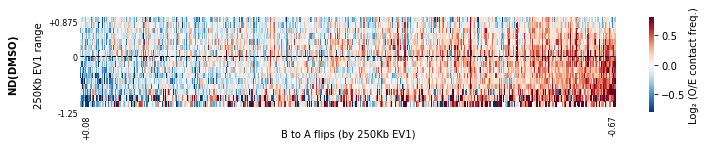

In [57]:
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,1.75)) 
cmap=sns.color_palette("RdBu_r", as_cmap=True)
sns.heatmap(ND_T97_binned_all_log,
            cmap=cmap, 
            vmin=-0.8, 
            vmax=0.8, 
            ax=ax,
            xticklabels=True,
            cbar_kws={"shrink": 1, "aspect":20, "label":'Log\N{SUBSCRIPT TWO} (O/E contact freq.)'}
           )
ax.axhline(y=7, color='k', linewidth=1, linestyle='--')
ax.tick_params(tick1On=False)
ylabels=['+0.875','0','-1.25']
ax.set_yticks((0.75,7,17))
ax.set_yticklabels(ylabels, fontsize=8,rotation=0)
ax.tick_params(axis='y', pad=-1.5)
plt.ylabel('$\\bf{ND (DMSO)}$\n\n250Kb EV1 range')
plt.xlabel('B to A flips (by 250Kb EV1)', labelpad=-10)
ax.tick_params(tick1On=False)
ax.set_xticks((6,481))
xlabels=['+0.08','-0.67']
ax.set_xticklabels(xlabels,fontsize=8)
ax.tick_params(axis='x', pad=-1.5)
#plt.savefig('*.pdf',dpi=300)


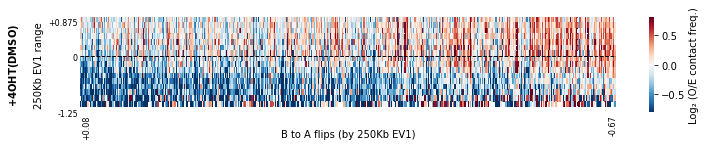

In [58]:
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,1.75)) 
cmap=sns.color_palette("RdBu_r", as_cmap=True)
sns.heatmap(fOHT_T97_binned_all_log,
            cmap=cmap, 
            vmin=-0.8, 
            vmax=0.8, 
            ax=ax,
            xticklabels=True,
            cbar_kws={"shrink": 1, "aspect":20, "label":'Log\N{SUBSCRIPT TWO} (O/E contact freq.)'}
           )
ax.axhline(y=7, color='k', linewidth=1, linestyle='--')
ax.tick_params(tick1On=False)
ylabels=['+0.875','0','-1.25']
ax.set_yticks((0.75,7,17))
ax.set_yticklabels(ylabels, fontsize=8,rotation=0)
ax.tick_params(axis='y', pad=-1.5)
plt.ylabel('$\\bf{+4OHT (DMSO)}$\n\n250Kb EV1 range')
plt.xlabel('B to A flips (by 250Kb EV1)', labelpad=-10)
ax.tick_params(tick1On=False)
ax.set_xticks((6,481))
xlabels=['+0.08','-0.67']
ax.set_xticklabels(xlabels,fontsize=8)
ax.tick_params(axis='x', pad=-1.5)
#plt.savefig('*.pdf',dpi=300)


In [59]:
diff=fOHT_T97_binned_all_log.subtract(ND_T97_binned_all_log,fill_value=0)


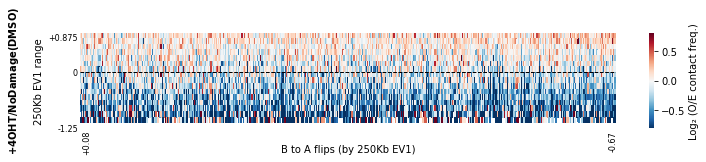

In [60]:
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,1.75)) 
cmap=sns.color_palette("RdBu_r", as_cmap=True)
sns.heatmap(diff,
            cmap=cmap, 
            vmin=-0.8, 
            vmax=0.8, 
            ax=ax,
            xticklabels=True,
            cbar_kws={"shrink": 1, "aspect":20, "label":'Log\N{SUBSCRIPT TWO} (O/E contact freq.)'}
           )
ax.axhline(y=7, color='k', linewidth=1, linestyle='--')
ax.tick_params(tick1On=False)
ylabels=['+0.875','0','-1.25']
ax.set_yticks((0.75,7,17))
ax.set_yticklabels(ylabels, fontsize=8,rotation=0)
ax.tick_params(axis='y', pad=-1.5)
plt.ylabel('$\\bf{+4OHT/No Damage (DMSO)}$\n\n250Kb EV1 range')
plt.xlabel('B to A flips (by 250Kb EV1)', labelpad=-10)
ax.tick_params(tick1On=False)
ax.set_xticks((6,481))
xlabels=['+0.08','-0.67']
ax.set_xticklabels(xlabels,fontsize=8)
ax.tick_params(axis='x', pad=-1.5)
#plt.savefig('*.pdf',dpi=300)


# Plot interactions for Top97 AsiS1 digested sites grouped by EV1

In [36]:
##cis
##NB: index 0 to 33 are actually A in the pooled control
ND_T97_binned_all=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-ND-dmso-p.mm10.250000.interactions_at_T97_cisgrouped_allchroms.bed', sep='\t')
ND_T97_binned_all=ND_T97_binned_all[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88']]
ND_T97_binned_all = ND_T97_binned_all.iloc[3:21 , :]
ND_T97_binned_all_log=ND_T97_binned_all.applymap(np.log2)
ND_T97_binned_all_log = ND_T97_binned_all_log.iloc[: , :89]

fOHT_T97_binned_all=pd.read_csv('/nl/umw_job_dekker/users/as38w/JZ-MEF-2020/sampled_2022/data/interactionsplots/MEF-4OHT-dmso-p.mm10.250000.interactions_at_T97_cisgrouped_allchroms.bed', sep='\t')
fOHT_T97_binned_all=fOHT_T97_binned_all[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88']]
fOHT_T97_binned_all = fOHT_T97_binned_all.iloc[3:21 , :]
fOHT_T97_binned_all_log=fOHT_T97_binned_all.applymap(np.log2)
fOHT_T97_binned_all_log = fOHT_T97_binned_all_log.iloc[: , :89]
ND_T97_binned_all_log.head()


/home/as38w/miniconda3/envs/coolerenv_manual_master/lib/python3.7/site-packages/pandas/core/frame.py:7603: RuntimeWarning: divide by zero encountered in log2
  return lib.map_infer(x.astype(object)._values, func)


,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
3,0.636736,0.615717,1.069494,1.273618,0.870994,1.004515,1.099919,1.151455,0.953773,1.362776,...,-0.582666,-0.190193,-0.471581,-0.657090,-0.210941,-1.194307,-0.430820,-0.469917,-0.075241,-0.903148
4,0.806579,0.946752,1.442805,1.254525,1.436038,1.082452,0.869715,1.245348,0.926414,0.587760,...,-0.188056,-0.131498,-0.231337,-0.345723,-0.147743,-0.416519,-0.336448,-0.596389,0.051268,-0.735485
5,0.749427,0.938675,1.110293,0.949300,0.266152,0.867340,0.651736,0.717808,0.940949,0.477912,...,-0.009868,0.263357,-0.220848,-0.085691,-0.105766,-0.650139,-0.044088,-0.574280,-0.048465,-0.693025
6,0.268813,0.585471,0.736587,0.627344,-0.139914,0.503746,0.474595,0.757834,0.641828,0.321564,...,0.068421,0.470758,-0.028678,0.011811,0.154013,-0.770381,0.061095,-0.264593,0.409837,-0.459066
7,0.118334,0.393684,0.317503,0.442165,-0.625099,0.469692,0.286723,0.644532,0.127768,0.386486,...,0.471137,0.494799,0.092933,0.386660,0.159371,-0.336739,0.160286,-0.005856,0.078576,-0.653255


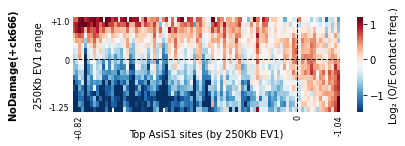

In [37]:
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(6,1.75)) 
cmap=sns.color_palette("RdBu_r", as_cmap=True)
sns.heatmap(ND_T97_binned_all_log,
            cmap=cmap, 
            vmin=-1.5, 
            vmax=1.2, 
            ax=ax,
            xticklabels=True,
            cbar_kws={"shrink": 1, "aspect":17, "label":'Log\N{SUBSCRIPT TWO} (O/E contact freq.)'}
           )
ax.axvline(x=74.5, color='k', linewidth=1, linestyle='--')
ax.axhline(y=8, color='k', linewidth=1, linestyle='--')
ax.tick_params(tick1On=False)
ylabels=['+1.0','0','-1.25']
ax.set_yticks((0.75,8,17))
ax.set_yticklabels(ylabels, fontsize=8,rotation=0)
ax.tick_params(axis='y', pad=0)
plt.ylabel('$\\bf{No Damage (+ck666)}$\n\n250Kb EV1 range')
plt.xlabel('Top AsiS1 sites (by 250Kb EV1)', labelpad=-10)
ax.tick_params(tick1On=False)
ax.set_xticks((2,75,88.5))
xlabels=['+0.82','0','-1.04']
ax.set_xticklabels(xlabels,fontsize=8)
ax.tick_params(axis='x', pad=-1.5)

#plt.savefig('*.pdf',dpi=300)


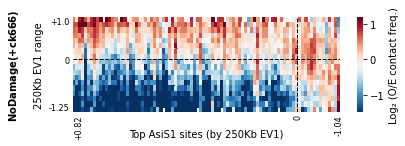

In [38]:
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(6,1.75)) 
cmap=sns.color_palette("RdBu_r", as_cmap=True)
sns.heatmap(fOHT_T97_binned_all_log,
            cmap=cmap, 
            vmin=-1.5, 
            vmax=1.2, 
            ax=ax,
            xticklabels=True,
            cbar_kws={"shrink": 1, "aspect":17, "label":'Log\N{SUBSCRIPT TWO} (O/E contact freq.)'}
           )
ax.axvline(x=74.5, color='k', linewidth=1, linestyle='--')
ax.axhline(y=8, color='k', linewidth=1, linestyle='--')
ax.tick_params(tick1On=False)
ylabels=['+1.0','0','-1.25']
ax.set_yticks((0.75,8,17))
ax.set_yticklabels(ylabels, fontsize=8,rotation=0)
ax.tick_params(axis='y', pad=0)
plt.ylabel('$\\bf{No Damage (+ck666)}$\n\n250Kb EV1 range')
plt.xlabel('Top AsiS1 sites (by 250Kb EV1)', labelpad=-10)
ax.tick_params(tick1On=False)
ax.set_xticks((2,75,88.5))
xlabels=['+0.82','0','-1.04']
ax.set_xticklabels(xlabels,fontsize=8)
ax.tick_params(axis='x', pad=-1.5)

#plt.savefig('*.pdf',dpi=300)

In [39]:
diff=fOHT_T97_binned_all_log.subtract(ND_T97_binned_all_log,fill_value=0)


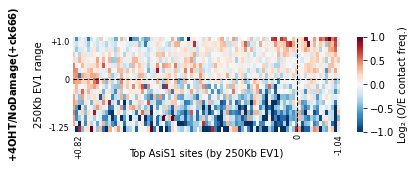

In [40]:
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(figsize=(6,1.75)) 
cmap=sns.color_palette("RdBu_r", as_cmap=True)
sns.heatmap(diff,
            cmap=cmap, 
            vmin=-1, 
            vmax=1, 
            ax=ax,
            xticklabels=True,
            cbar_kws={"shrink": 1, "aspect":17, "label":'Log\N{SUBSCRIPT TWO} (O/E contact freq.)'}
           )
ax.axvline(x=74.5, color='k', linewidth=1, linestyle='--')
ax.axhline(y=8, color='k', linewidth=1, linestyle='--')
ax.tick_params(tick1On=False)
ylabels=['+1.0','0','-1.25']
ax.set_yticks((0.75,8,17))
ax.set_yticklabels(ylabels, fontsize=8,rotation=0)
ax.tick_params(axis='y', pad=0)
plt.ylabel('$\\bf{+4OHT/No Damage (+ck666)}$\n\n250Kb EV1 range')
plt.xlabel('Top AsiS1 sites (by 250Kb EV1)', labelpad=-10)
ax.tick_params(tick1On=False)
ax.set_xticks((2,75,88.5))
xlabels=['+0.82','0','-1.04']
ax.set_xticklabels(xlabels,fontsize=8)
ax.tick_params(axis='x', pad=-1.5)
#plt.savefig('*.pdf',dpi=300)
